In [7]:
import os
import sys
import pandas as pd 
import argparse
import numpy as np 
import glob
import time 
import logging
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle
import multiprocessing
from multiprocessing import  Pool
import time
import logging
from functools import partial
import random
from functools import reduce
import tqdm

def plot_metagene(result, plot_group = 'alias', facet_by = None, x_col = 'pos', y_col = 'count', shade = None, title = None, sharey = False, vline = False, ylim = None) : 
    
    plot = sns.FacetGrid(result, 
                         col = facet_by, 
                         hue = plot_group, 
                         height = 4, 
                         aspect = 1.3, 
                        col_wrap = 2)

    plot.map(sns.lineplot, x_col, y_col)
        
    plot.add_legend()
    
    if shade : 
            result['m'] = result[y_col] - result[shade]
            result['M'] = result[y_col] + result[shade]
            plot.map(plt.fill_between, x_col, 'm', 'M', alpha=0.2)
            
    if vline : 
        plt.axvline(x = vline, color = 'grey', label = f'{vline} bp', alpha = 0.5)
    
    
    if title : 
        plot.fig.suptitle(f'{title}')
        
    if ylim : 
        plot.set(ylim=(0, ylim))
    
    return plot

def parse_transcripts(transcripts) : 
    
    windows = {}
    seq = ''
    i = 0
    with open(transcripts, 'r') as f : 
        for line in f :
            if line.startswith(">") :
                info = line.strip().replace(">","")
                if i == 1 :
                    windows[info] = [ [0, len(seq)] ]
                    seq = ''
                    i = 0
                i += 1
            else : 
                seq += line.strip()
        else : 
            windows[info] = [ [0, len(seq)] ]
    
    return windows

def parse_windows(bed_windows) : 

    windows = {}
    N = 0
    if isinstance(bed_windows, pd.DataFrame) : 
        for index,row in bed_windows.iterrows() : 
            
            gene = bed_windows.iloc[index][0]
            start = int(bed_windows.iloc[index][1])
            end = int(bed_windows.iloc[index][2])
            
            if gene in windows.keys() : 
                    windows[gene].append([start, end])
            else : 
                windows[gene] = [ [start, end] ]
            N += 1
    else :
        with open(bed_windows, 'r') as f : 
            for line in f : 
                info = line.strip().split("\t")
                gene = info[0]
                start = int(info[1])
                end = int(round(float(info[2])))

                if gene in windows.keys() : 
                    windows[gene].append([start, end])
                else : 
                    windows[gene] = [ [start, end] ]
                
                N += 1
                    
    print(f"Number of windows/transcripts: {N}")
    return windows

def reformat_bedfile(FILES, outdir) : 
    
    if not os.path.exists(outdir) : 
        os.mkdir(outdir)
        
    for F in FILES : 
        name = os.path.basename(F).replace(".bed.tsv", ".rpm")
        outname = os.path.join(outdir, name)
        
        if not os.path.exists(name) :
            
            lines = ''
            with open(F, 'r') as f : 
                for line in f : 
                    if not line.startswith("gene") : 
                        info = line.strip().split("\t")
                        lines += f"{info[0]}\t{info[1]}\t{info[2]}\t{info[3]}\t{info[7]}\t{info[5]}\n"
            f.close()

            out = open(outname, 'w')
            out.write(lines)
            out.close()

def calculate_coverage(bed, p5nt = ['G', 'A'], min_len = 21, max_len = 23, aggregate = 'density') : 
    
    bed_entries = 0 
    with open(bed, 'r') as f : 
        for line in f : 
            bed_entries += 1
    f.close()
        
    cov = {}
    bed_line = 0
    with open(bed, 'r') as f :
        for line in f : 
            if not (line.startswith('chrom')) and not (line.startswith("gene_name")) : 
                info = line.strip().split('\t')
                chrom = info[0]
                start = int(info[1])
                end = int(info[2])
                seq = str(info[3])
                five_prime = seq[0]
                
                if (five_prime in p5nt) and (len(seq) >= min_len and len(seq) <= max_len) : 
                    
                    count = float(info[4])
                    # make a dict for each gene + each 5' nucleotide
                    # cov > gene > A > pos
                    if not chrom in cov.keys() : 
                        cov[chrom] = {}
                    
                    
                    if not five_prime in cov[chrom].keys() : 
                        cov[chrom][five_prime] = {}
                        
                    if aggregate == 'density' : 
                        for i in range(start, end + 1) :
                            if i in cov[chrom][five_prime].keys() : 
                                cov[chrom][five_prime][i] += ( count / len(seq) )
                            else : 
                                cov[chrom][five_prime][i] = ( count / len(seq) )
                    elif aggregate == 'five_prime' : 
                        pos = end
                        if pos in cov[chrom][five_prime].keys() : 
                            cov[chrom][five_prime][pos] += count
                        else : 
                            cov[chrom][five_prime][pos] = count
                    else : 
                        print('Aggregate must be set to either [density OR five_prime]')
                        return 0 
                    
                        
            bed_line += 1
    f.close() 
    
    pklf = f"{bed}.cov.{''.join(p5nt)}.{aggregate}.pickle"
    with open(pklf, 'wb') as handle : 
        pickle.dump(cov, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    return cov

def calculate_metagene_coord(bed, windows = None, scaling = False, sample = None, p5nt = ['G', 'A'], combine_five_prime_nt = False, aggregate = 'density', missing_data_as_0 = False, sum_coverage = False, normalize_number_windows = True) :
    
    time1 = time.time()

    pklf = f"{bed}.cov.{''.join(p5nt)}.{aggregate}.pickle"

    if not os.path.exists(pklf) : 
        meta_info = calculate_coverage(bed, p5nt = p5nt, aggregate = aggregate)
    else : 
        with open(pklf, 'rb') as handle : 
            meta_info = pickle.load(handle)
    
    if not sample : 
        sample = os.path.basename(bed).split(".")[0]
    
    positions = []
    counts = []
    five_prime_nts = []
    genes = []
    
    if not windows : 
        return 0
    
    total_windows = len(windows.keys())
    tracker = 1
    for gene,win_coord in windows.items() :
        for sub_win in win_coord :
            if gene in meta_info.keys() :
                for nt in meta_info[gene].keys() : 
                    if nt in p5nt :
                        cov = meta_info[gene][nt]
                        cov_sub = {}
                        
                        for i in range(sub_win[0], sub_win[1]+1) : 
                            if i in cov.keys() : 
                                cov_sub[i] = cov[i]
                            else : 
                                if missing_data_as_0 :
                                    cov_sub[i] = 0
                                    
                        if bool(cov_sub) : 

                            win_size = sub_win[1] - sub_win[0] + 1

                            if scaling :
                                cov_sub_scaled = [ [(round(100*( (k-sub_win[0])/win_size)*5)/5), v] for k,v in cov_sub.items() ] 
                            else :
                                cov_sub_scaled = [ [(k-sub_win[0]), v] for k,v in cov_sub.items() ]

                            positions.extend([ i[0] for i in cov_sub_scaled ])
                            
                            if normalize_number_windows : 
                                counts.extend([ i[1]/total_windows for i in cov_sub_scaled ])
                            else : 
                                counts.extend([ i[1] for i in cov_sub_scaled ])
                            
                            if sum_coverage : 
                                genes.extend([ gene for i in range(0,len(cov_sub_scaled)) ] )

                            if combine_five_prime_nt : 
                                five_prime_nts.extend([ ','.join(p5nt) for i in range(0,len(cov_sub_scaled)) ])
                            else : 
                                five_prime_nts.extend([ nt for i in range(0,len(cov_sub_scaled)) ])
        
        #print(f'{tracker} of {total_windows} ({ round(( (tracker)/(total_windows) )*100,2) }%) genes processed', end='\r')
        tracker += 1
    
    if not sum_coverage : 
        df1 = pd.DataFrame({
            'pos' : positions,
            'count' : counts, 
            'five_prime_nt' : five_prime_nts,
            'alias' : f"{sample}", 
            'type' : 'density'
        })
    else : 
        df1 = pd.DataFrame({
            'pos' : positions,
            'count' : counts, 
            'five_prime_nt' : five_prime_nts,
            'alias' : f"{sample}", 
            'type' : 'density',
            'gene' : genes
        })
    
    if not sum_coverage : 
        res = df1.groupby(['pos', 'alias', 'type', 'five_prime_nt'])['count'].sum().reset_index()
        res['zscore'] = 2**((res['count'] - res['count'].mean())/res['count'].std(ddof=0))
    else :
        res = df1.groupby(['gene', 'alias', 'type', 'five_prime_nt'])['count'].sum().reset_index()
    
    
    if not sum_coverage : 
        if scaling :
            if windows :
                res = res.query('pos < 100 & pos > 0')
            
    time2 = time.time() 
    print(f"Processing {sample} took {time2 - time1} s")
    
    return res


class metagene() : 
    
    def __init__(self, files, bed_windows = None, scaling = False, transcripts = None, sample = None, p5nt = None, min_len = 21, max_len = 23, sum_coverage = False, combine_five_prime_nt = False, aggregate = 'density', missing_data_as_0 = False, normalize_number_windows = True) : 
        
        self._files = files
        self._bed_windows = bed_windows
        self._scaling = scaling 
        self._transcripts = transcripts
        self._sample = sample
        self._p5nt = p5nt if p5nt is not None else ['G', 'A']
        self._min_len = min_len if min_len is not None else 21
        self._max_len = max_len if max_len is not None else 23
        self._sum_coverage = sum_coverage
        self._combine_five_prime_nt = combine_five_prime_nt
        self._aggregate = aggregate
        self._missing_data_as_0 = missing_data_as_0
        self._normalize_number_windows = normalize_number_windows
    
    def parse_windows(self) :
        
        if isinstance(self._bed_windows, pd.DataFrame) : 
            my_windows = parse_windows(self._bed_windows)
        elif self._bed_windows :
            my_windows = parse_windows(self._bed_windows)
        elif self._transcripts :
            my_windows = parse_transcripts(self._transcripts)
        else :
            print("Neither bed or transcripts provided...exiting")
            return 0
        
        self._windows = my_windows
    
    def parallel_metagene(self) :
        
        args = []
        for f in self._files : 
            args.append([f] + [
                self._windows, 
                self._scaling, 
                self._sample, 
                self._p5nt, 
                self._combine_five_prime_nt, 
                self._aggregate, 
                self._missing_data_as_0, 
                self._sum_coverage,
                self._normalize_number_windows
            ])
        pool = Pool(multiprocessing.cpu_count()-2)
        df = pd.concat(pool.starmap(calculate_metagene_coord, args))
        pool.close()
        pool.join()
        
        self._result = df
    
    def execute(self) : 
        
        self.parse_windows()
        self.parallel_metagene()
        return self._result

# Metagene analysis using CLASH

In [87]:
# read in target sites

targets = pd.read_csv("/fs/ess/PAS1473/ben_past_projects/clash_prg1_rep1/prg1_clash1_master_table.tsv", sep = '\t')
targets = targets.query('dG <= -20 and count >= 5')

target_bed = targets[['target', 'target_start', 'target_end_adj', 'smRNA', 'count', 'strand']].reset_index(drop = True)

target_bed['start'] = target_bed['target_end_adj'] - 50 
target_bed['end'] = target_bed['target_end_adj'] + 50 

target_bed

,target,target_start,target_end_adj,smRNA,count,strand,start,end
0,CELE14B,3,20,21ur-3324,5,-,-30,70
1,CELE45,74,94,21ur-1122,7,-,44,144
2,CELE45,49,74,21ur-4670,6,-,24,124
3,CELE45,184,204,21ur-5209,9,-,154,254
4,CELE46B,174,198,21ur-1097,12,-,148,248
...,...,...,...,...,...,...,...,...
55865,"WBGene00306078,Y51H7C.42",834,853,21ur-1503,7,-,803,903
55866,"WBGene00306078,Y51H7C.42",783,804,21ur-3545,7,-,754,854
55867,"WBGene00306078,Y51H7C.42",412,435,21ur-4636,6,-,385,485
55868,"WBGene00306078,Y51H7C.42",1041,1061,21ur-4656,7,-,1011,1111


In [88]:
# get piRNAs w/ antisense 

piRNA = pd.read_table("../antipiRNA_bed_master_filtered.tsv")

antipiRNA = piRNA.query('feature == "antipiRNA" and sample == "parn_YD1" or sample == "parn_YD2"').drop_duplicates()

antipiRNA['piRNA'] = antipiRNA.apply(lambda x: x['gene'].split(",")[2], axis = 1)

antipiRNA_list = antipiRNA['piRNA'].drop_duplicates().tolist()

len(antipiRNA_list)

1934

In [89]:
files = glob.glob("./10_18_metagene/*parn*YD*rpm")

In [90]:
run = metagene(files,
                  bed_windows = target_bed.query('smRNA in @antipiRNA_list').reset_index(drop = True)[['target', 'start', 'end']],
                  scaling = False,
                  transcripts = None,
                  sample = None,
                  p5nt = ['A', 'G'],
                  min_len = 21,
                  max_len = 23,
                  combine_five_prime_nt = True,
                  missing_data_as_0 = False,
                  aggregate = 'density')
anti = run.execute()
anti_grouped = anti.groupby(['pos', 'five_prime_nt']).agg(count = ('count', 'mean'), S = ('count', 'std')).reset_index()
anti_grouped['group'] = 'with_anti'

Number of windows/transcripts: 16030
Processing parn_YD1 took 3.6948654651641846 s
Processing parn_YD2 took 3.73747181892395 s


In [91]:
run = metagene(files,
               bed_windows = target_bed.query('smRNA not in @antipiRNA_list').reset_index(drop = True)[['target', 'start', 'end']],
               scaling = False,
               transcripts = None,
               sample = None,
               p5nt = ['A', 'G'],
               min_len = 21,
               max_len = 23,
               combine_five_prime_nt = True,
               missing_data_as_0 = False,
               aggregate = 'density')
non_anti = run.execute()
non_anti_grouped = non_anti.groupby(['pos', 'five_prime_nt']).agg(count = ('count', 'mean'), S = ('count', 'std')).reset_index()
non_anti_grouped['group'] = 'without_anti'

Number of windows/transcripts: 39840
Processing parn_YD1 took 6.092387676239014 s
Processing parn_YD2 took 6.312169790267944 s


In [92]:
master = pd.concat([anti_grouped, non_anti_grouped], ignore_index = True)

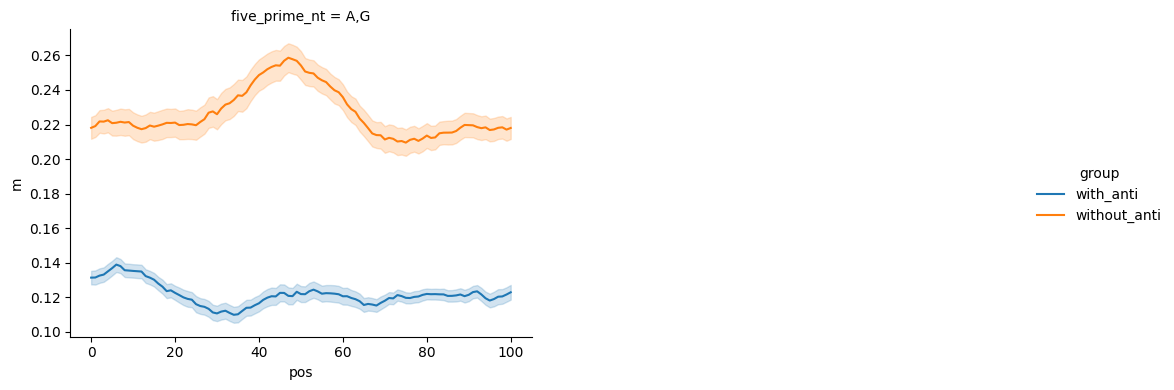

In [93]:
plot_metagene(master,
              shade = 'S', 
              x_col = 'pos', 
              y_col = 'count', 
              facet_by = 'five_prime_nt',
              plot_group = 'group'
             )

In [96]:
for e,i in enumerate(range(0,10)) : 
    
    run = metagene(files,
                  bed_windows = target_bed.query('smRNA not in @antipiRNA_list').sample(n=16030, random_state=i).reset_index(drop = True)[['target', 'start', 'end']],
                  scaling = False,
                  transcripts = None,
                  sample = None,
                  p5nt = ['A', 'G'],
                  min_len = 21,
                  max_len = 23,
                  combine_five_prime_nt = True,
                  missing_data_as_0 = False,
                  aggregate = 'density')
    tmp = run.execute()
    tmp_grouped = tmp.groupby(['pos', 'five_prime_nt']).agg(count = ('count', 'mean')).reset_index()
    
    if e == 0 : 
        res = tmp_grouped
    else : 
        res = pd.concat([res, tmp_grouped], ignore_index = True)

Number of windows/transcripts: 16030
Processing parn_YD1 took 3.3957407474517822 s
Processing parn_YD2 took 3.4441654682159424 s
Number of windows/transcripts: 16030
Processing parn_YD1 took 3.3684329986572266 s
Processing parn_YD2 took 3.4585366249084473 s
Number of windows/transcripts: 16030
Processing parn_YD1 took 3.332357406616211 s
Processing parn_YD2 took 3.37180757522583 s
Number of windows/transcripts: 16030
Processing parn_YD1 took 3.3295867443084717 s
Processing parn_YD2 took 3.3942558765411377 s
Number of windows/transcripts: 16030
Processing parn_YD1 took 3.6018526554107666 s
Processing parn_YD2 took 3.706735372543335 s
Number of windows/transcripts: 16030
Processing parn_YD1 took 3.3930864334106445 s
Processing parn_YD2 took 3.498563289642334 s
Number of windows/transcripts: 16030
Processing parn_YD1 took 3.4474716186523438 s
Processing parn_YD2 took 3.504467248916626 s
Number of windows/transcripts: 16030
Processing parn_YD1 took 3.4796485900878906 s
Processing parn_YD2 

In [97]:
res['group'] = 'random_control'

random_grouped = res.groupby(['pos', 'five_prime_nt', 'group']).agg(count = ('count', 'mean'), S = ('count', 'std')).reset_index()

In [98]:
anti_plus_random = pd.concat([anti_grouped, random_grouped], ignore_index = True)

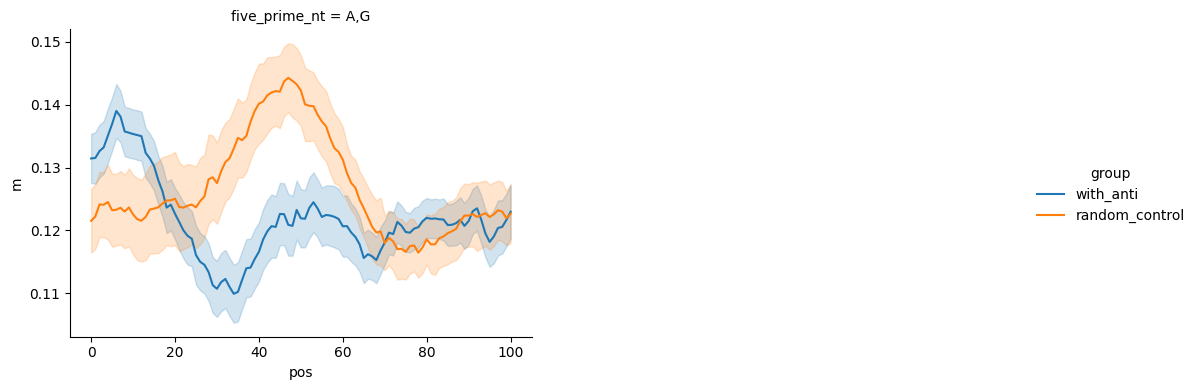

In [99]:
plot_metagene(anti_plus_random,
              shade = 'S', 
              x_col = 'pos', 
              y_col = 'count', 
              facet_by = 'five_prime_nt',
              plot_group = 'group'
             )

# Metagene analysis using prediction of 26U RNAs

In [18]:
piRNA_rpm = pd.read_csv("/fs/ess/PCON0160/ben/projects/reannotate_piRNAs/alignment/master_tables/alignment.aligned.v0.m1.count_total_norm.tsv", sep = "\t")

IP = piRNA_rpm.query(
    'feature == "piRNA"'
).drop(
    columns = ['tor149GFP::3xFLAG::prg1_I_inputtotalRNA_1', 'tor149GFP::3xFLAG::prg1_I_inputtotalRNA_2', 'class', 'feature', 'biotype', 'seq_id', 'gene_name']
).set_index('locus_id')

IP['IP_mean'] = IP.mean(axis = 1)

IP = IP.drop(columns = ['tor149GFP::3xFLAG::prg1_I_IPArgonaute_2', 'tor149GFP::3xFLAG::prg1_I_IPArgonaute_1']).reset_index()

perc = round(IP.shape[0]*0.25)

top_piRNA = IP.nlargest(perc, 'IP_mean').locus_id.tolist()
bottom_piRNA = IP.nsmallest(perc, 'IP_mean').locus_id.tolist()


In [55]:
tar_pred = pd.read_table("/fs/ess/PCON0160/ben/projects/antisense_piRNA_v2/pirna_ts_prediction/target_sites.bed")

tar_pred['start'] = tar_pred['end'] - 50
tar_pred['end'] = tar_pred['end'] + 50

In [56]:
tar_pred_slim = tar_pred[['chrom', 'start', 'end', 'piRNA', 'seed_mm', 'other_mm']]
tar_pred_slim.head()

,chrom,start,end,piRNA,seed_mm,other_mm
0,CELE2,93,193,21ur-12297,1,3
1,CELE2,247,347,21ur-12794,2,1
2,CELE46B,92,192,21ur-4384,1,4
3,CER1,8,108,21ur-3296,1,3
4,CER1,4111,4211,21ur-7929,1,3


In [76]:
all_ts = tar_pred_slim.query('seed_mm <= 2').reset_index(drop = True)
top20 = all_ts.query('piRNA in @top_piRNA').reset_index(drop = True)
bottom20 = all_ts.query('piRNA in @bottom_piRNA').reset_index(drop = True)


In [77]:
anti_piRNAs = all_ts.query('piRNA in @antipiRNA_list').reset_index(drop = True)


In [81]:
windows = [
    #['all (seed mm <= 2, other mm <= 3)', all_ts], 
    ['top 20% piRNA by PRG-1 IP', top20],
    ['bottom 20% piRNA by PRG-1 IP', bottom20],
    ['antipiRNAs', anti_piRNAs]
]

Number of windows/transcripts: 1123
Processing parn_YD2 took 1.7369794845581055 s
Processing parn_YD1 took 1.7354326248168945 s
Number of windows/transcripts: 1305
Processing parn_YD1 took 1.7228500843048096 s
Processing parn_YD2 took 1.8071722984313965 s
Number of windows/transcripts: 640
Processing parn_YD2 took 1.6451196670532227 s
Processing parn_YD1 took 1.663297414779663 s


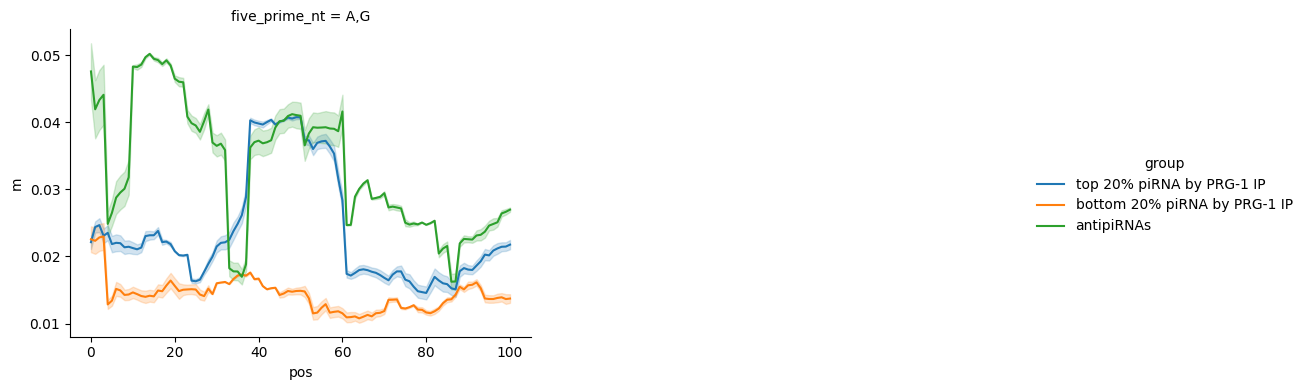

In [83]:
for e,w in enumerate(windows) :
    run = metagene(files,
                  bed_windows = w[1],
                  scaling = False,
                  transcripts = None,
                  sample = None,
                  p5nt = ['A', 'G'],
                  min_len = 21,
                  max_len = 23,
                  combine_five_prime_nt = True,
                  missing_data_as_0 = True,
                  aggregate = 'density',
                  normalize_number_windows=True)
    tmp = run.execute()
    tmp_gr = tmp.groupby(['pos', 'five_prime_nt']).agg(count = ('count', 'mean'), S = ('count', 'std')).reset_index()
    tmp_gr['group'] = w[0]
    if e == 0 : 
        res = tmp_gr 
    else : 
        res = pd.concat([res, tmp_gr], ignore_index = True)

plot_metagene(res,
          shade = 'S', 
          x_col = 'pos', 
          y_col = 'count', 
          facet_by = 'five_prime_nt',
          plot_group = 'group'
         )      